In [1]:
import logging
import os
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import geoviews.feature as gf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uxarray
import xarray

try:  # Avoid ValueError when assigning cmap again
    cmap = cmaps.WhiteBlueGreenYellowRed
except ValueError:
    pass

In [2]:
uxarray.__version__

'2025.6.0'

In [3]:
figw = 12
projection = ccrs.LambertConformal(central_longitude=-82, standard_parallels=(30, 60))

## Plot TC centers with radius of influence and location of maximum
### optional filter by hemisphere or quandrant about center point

### HWT 2023 MPAS

In [4]:
idate = pd.to_datetime("20230531")
base_path = (
    Path("/glade/campaign/mmm/parc/schwartz/HWT2023/mpas")
    / idate.strftime("%Y%m%d%H")
    / "post/mem_4"
)
grid_path = "/glade/campaign/mmm/parc/schwartz/MPAS/15-3km_mesh/mpas_init/static.nc"
# Paths to Data Variable files
data_paths = [
    d.strftime("diag.%Y-%m-%d_%H.%M.%S.nc")
    for d in pd.date_range(
        start=idate + pd.Timedelta(hours=6),
        # up to 132 hours
        end=idate + pd.Timedelta(hours=72),
        freq="6h",
    )
]
data_paths = [base_path / name for name in data_paths]
# Pre-Tropical storm ARLENE
track = pd.DataFrame(
    data=[
        (pd.to_datetime("20230531T06"), -87.6, 27.6),
        (pd.to_datetime("20230531T12"), -87.6, 27.8),
        (pd.to_datetime("20230531T18"), -87.5, 28.0),
        (pd.to_datetime("20230601T00"), -87.4, 28.4),
        (pd.to_datetime("20230601T06"), -87.4, 28.5),
        (pd.to_datetime("20230601T12"), -87.5, 28.5),
        (pd.to_datetime("20230601T18"), -87.5, 28.6),
        (pd.to_datetime("20230602T00"), -87.6, 28.7),
        (pd.to_datetime("20230602T06"), -87.6, 28.6),
        (pd.to_datetime("20230602T12"), -87.6, 28.3),
        (pd.to_datetime("20230602T18"), -87.5, 27.6),
        (pd.to_datetime("20230603T00"), -87.4, 27.1),
    ],
    columns=["valid_time", "lon", "lat"],
).set_index("valid_time")
assert not any(track.index.duplicated())

time = pd.Timestamp("20230531T06")

In [5]:
%%time
uxds = uxarray.open_mfdataset(
    grid_path,
    data_paths,
    concat_dim="Time",
    combine="nested",
    use_dual=False,
)
uxds = uxds.assign_coords(
    Time=[
        pd.to_datetime(x.decode().rstrip(), format="%Y-%m-%d_%H:%M:%S")
        for x in uxds.xtime.values
    ]
)
uxds.source_datasets

CPU times: user 2.65 s, sys: 28.6 s, total: 31.3 s
Wall time: 36.3 s


"[PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-05-31_06.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-05-31_12.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-05-31_18.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-06-01_00.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-06-01_06.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-06-01_12.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-06-01_18.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-06-02_00.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-06-02_06.00.00.nc'),

In [6]:
uxds

<xarray.UxDataset> Size: 32GB
Dimensions:                 (Time: 12, n_face: 6488066, n_node: 12976128,
                             nSoilLevels: 4)
Coordinates:
  * Time                    (Time) datetime64[ns] 96B 2023-05-31T06:00:00 ......
Dimensions without coordinates: n_face, n_node, nSoilLevels
Data variables: (12/100)
    initial_time            (Time) |S64 768B b'2023-05-31_00:00:00           ...
    xtime                   (Time) |S64 768B dask.array<chunksize=(1,), meta=np.ndarray>
    olrtoa                  (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    rainc                   (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    rainnc                  (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    refl10cm_max            (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    ...                      ...
    vshr06                  (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    ushr01                  (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    vshr01                  (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    rainc_hrly              (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    rainnc_hrly             (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>
    total_precip_hrly       (Time, n_face) float32 311MB dask.array<chunksize=(1, 926867), meta=np.ndarray>

### Matplotlib backend works when browser cache is full and in github. Bokeh sometimes does not

:Overlay
   .Image.I     :Image   [x,y]   (x_y refl10cm_max)
   .Coastline.I :Feature   [Longitude,Latitude]
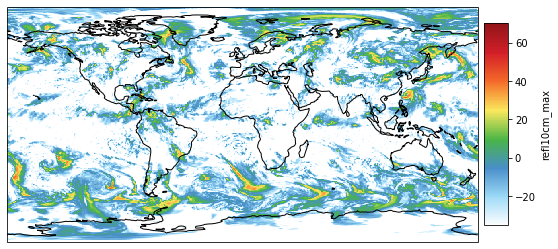

In [8]:
uxds["refl10cm_max"].sel(Time=time).plot.polygons(
    rasterize=True,
    backend="matplotlib",
    cmap=cmap,
    clim=(-35, 70),
) * gf.coastline(projection=ccrs.PlateCarree())

### Bokeh lets you zoom in and see more detail with dynamic=True

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [x,y]   (x_y refl10cm_max)
      .Coastline.I :Feature   [Longitude,Latitude]
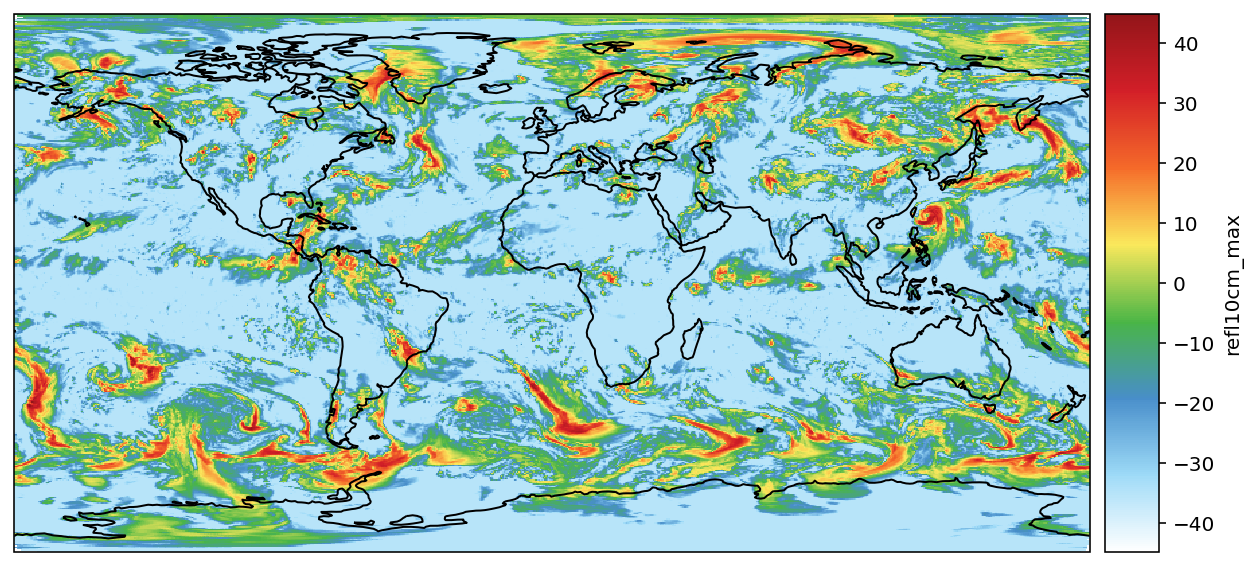

In [9]:
time = pd.Timestamp("20230531T06")
uxds["refl10cm_max"].sel(Time=time).plot.polygons(
    rasterize=True,
    width=800,
    height=400,
    dynamic=True,
    cmap=cmap,
    # clim=(-10, 50), # uncomment to freeze cbar limits when zooming
) * gf.coastline(projection=ccrs.PlateCarree())

<img src="https://s.w-x.co/util/image/w/Arlene%202023%20Recap.png?v=ap&w=980&h=551">

### Plot PlateCarree projection directly with uxarray

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [x,y]   (x_y refl10cm_max)
      .States.I :Feature   [Longitude,Latitude]
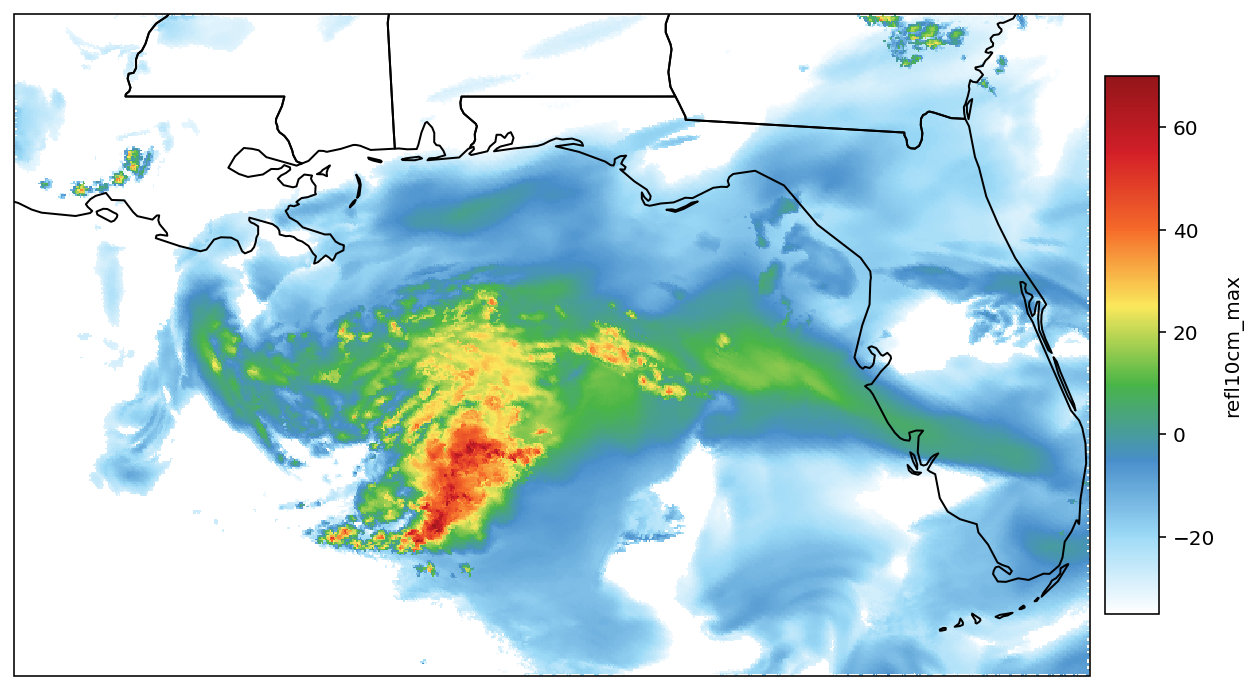

In [10]:
lat_bounds = 24, 32
lon_bounds = -93, -80
uxds["refl10cm_max"].subset.bounding_box(lon_bounds, lat_bounds).sel(Time=time).plot.polygons(
    rasterize=True,
    width=800,
    height=400,
    dynamic=True,
    cmap=cmap,
    clim=(-35, 70),
) * gf.states(projection=ccrs.PlateCarree(), scale="50m")

### Lambert conformal projection with hvplot

In [10]:
%%time
import holoviews
import hvplot.pandas

# holoviews.extension("matplotlib")

uxds["refl10cm_max"].subset.bounding_box(lon_bounds, lat_bounds).sel(
    Time=time
).to_geodataframe().hvplot.polygons(
    rasterize=True,
    cmap=cmap,
    c="refl10cm_max",
    geo=True,
    # grid=True, # must use matplotlib extension for this
    projection=projection,
    width=600,
    height=400,
    colorbar=True,
    clim=(-35, 70),
) * gf.states(
    projection=projection, scale="50m"
)

CPU times: user 1.05 s, sys: 86.4 ms, total: 1.14 s
Wall time: 1.37 s


:DynamicMap   []
   :Overlay
      .Image.I  :Image   [Longitude,Latitude]   (Longitude_Latitude refl10cm_max)
      .States.I :Feature   [Longitude,Latitude]

In [11]:
# holoviews.save(img, "t.png")

### Matplotlib-style multipanel scatterplot

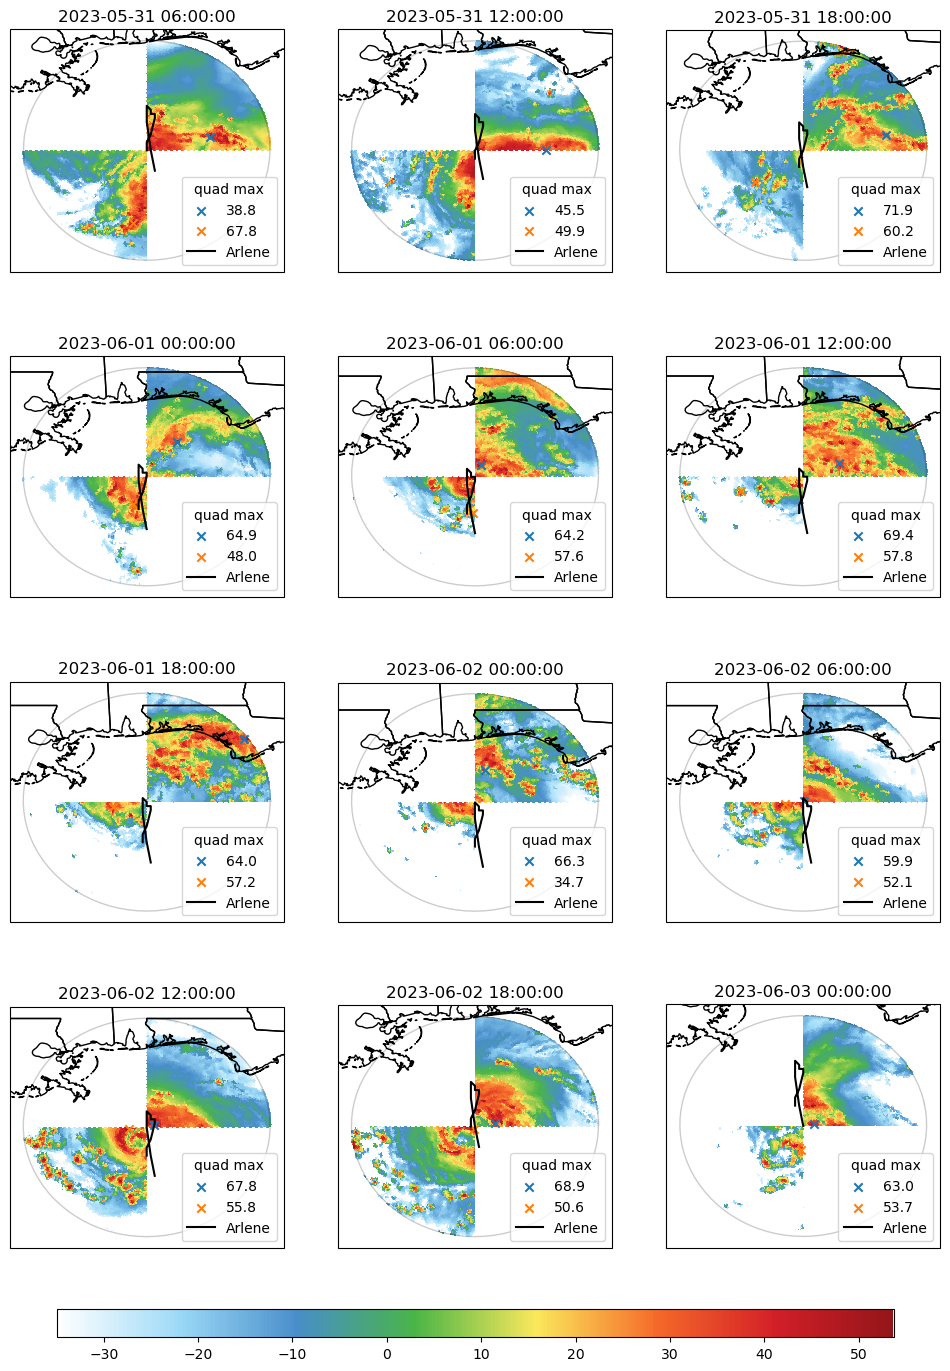

In [14]:
%matplotlib inline

warnings.filterwarnings("ignore", message="Approximating coordinate system")

ntimes = uxds.Time.size
ncols = int(np.round(np.sqrt(ntimes)))
nrows = int(np.ceil(ntimes / ncols))
fig, axes = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(figw, nrows * 5),
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)

for time, ax in zip(track.index, axes.flatten()):
    lon, lat = track.loc[time, ["lon", "lat"]]

    ax.tissot(
        rad_km=300,
        lons=lon,
        lats=lat,
        alpha=0.2,
        edgecolor="black",
        facecolor="none",
    )
    circ = uxds["refl10cm_max"].subset.bounding_circle((lon, lat), 300 / 111.0).sel(Time=time)
    ne = circ.subset.bounding_box((lon, 360), (lat, 90))
    sw = circ.subset.bounding_box((-360, lon), (-90, lat))

    for da in [ne, sw]:
        pc = da.to_polycollection()
        pc.set_antialiased(False)
        pc.set_cmap(cmap)
        ax.add_collection(pc)

        x = da.argmax()

        ax.scatter(
            da.uxgrid.face_lon.isel(n_face=x),
            da.uxgrid.face_lat.isel(n_face=x),
            transform=ccrs.PlateCarree(),
            marker="x",
            label=f"{da.max().compute().item():.1f}",
        )

    ax.plot(track.lon, track.lat, transform=ccrs.PlateCarree(), label="Arlene", color="k")
    ax.set_title(time)

    ax.add_feature(cfeature.STATES)

    ax.legend(title="quad max", loc="lower right")
cb = fig.colorbar(pc, ax=axes, orientation="horizontal", aspect=30, shrink=0.9, pad=0.04)

# <a href="./ESDSDemo-2.ipynb">notebook to upscale fine-mesh MPAS to coarse mesh</a>